In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from __future__ import unicode_literals, print_function, division
# import os, sys
# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
# os.environ["CUDA_VISIBLE_DEVICES"]="0"

from io import open
import glob
import os, sys
import unicodedata
import string
import time
import math
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from random import randint
from torch.autograd import Variable
import numpy as np
from numpy.random import shuffle
from common import *
from datasets.hanoi import *
# from models.arbtree import SpawnNet, ReadNet, DiscrimNet
from models.single import SpawnNet, ReadNet, DiscrimNet

In [2]:
class args:
    batch = 64
    iters = 50000
    readsize = 64
    readHidden = 64
    zsize = 8
    lr = 1e-4

In [3]:
ZSIZE = args.zsize
BSIZE = args.batch
READSIZE = args.readsize  # size of node readout
LR = args.lr
n_iters = args.iters

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
bhalf = BSIZE // 2
real_labels = Variable(torch.ones(bhalf, 1), requires_grad=False).to(device)
fake_labels = Variable(torch.zeros(bhalf, 1), requires_grad=False).to(device)
adversarial_loss = torch.nn.BCELoss().to(device)
TARGET = Hanoi
Tree.init(device, resolution=1, readsize=READSIZE)    # tree-level operations
Node.init(device)    # give device handle to nodes
MAX_HEIGHT = 1         # where root is 0


In [5]:
comment='''
Training Phases:

* Generative
1. For depth D = N
2. Gather target trees
3. Generate frontier for tree of depth D = N - 1
4. Adversarial training between target and generated
5. Repeat for D = 1 ... N

* Iterative
1. For trees of arb length
2. Gather target trees
3. Generate trees of arb depth until termination
3.5  Run message passing/iteration for T = M steps
4. Adversarial training of iteration model against target

'''

In [6]:
spawn = SpawnNet(zsize=ZSIZE).to(device)
readout = ReadNet(readsize=READSIZE, hidden=args.readHidden).to(device)
discrim = DiscrimNet(readsize=READSIZE).to(device)

# NOTE: dont tune readout here; it'll optimize to fool the discrim!
gen_opt = optim.Adam([
    { 'params': spawn.parameters() },
], lr=1e-4, weight_decay=1e-4)

# Readout aligns with discriminator
#  The goal of readout is to extract as much distinguishing info
#   from any samples shown
readout_opt = optim.Adam([
    { 'params': readout.parameters() },
    { 'params': discrim.parameters() },
], lr=1e-3, weight_decay=1e-4)

In [7]:
def norml1(val):
    # all inference normalized under fixed resolution of 64x64
    return val / 64

def denorml1(val):
    return val * 64

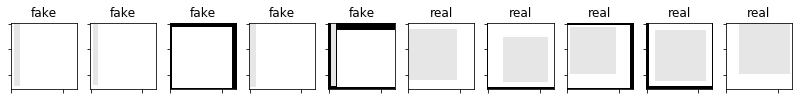

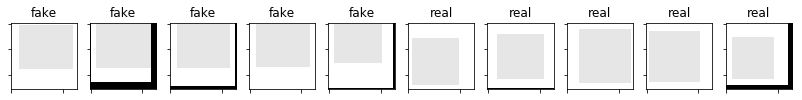

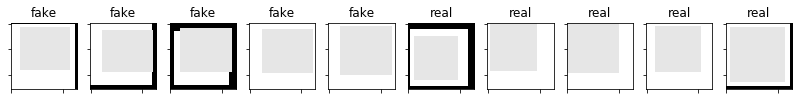

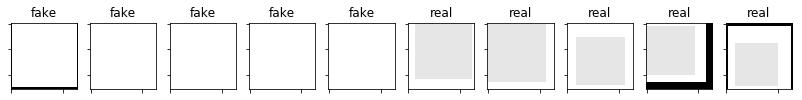

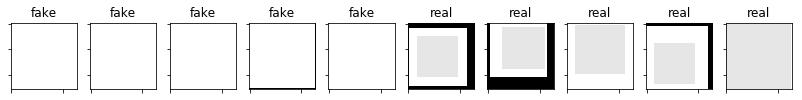

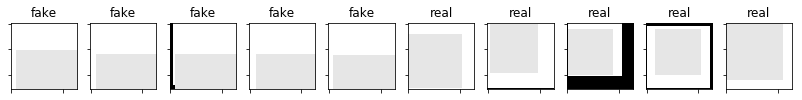

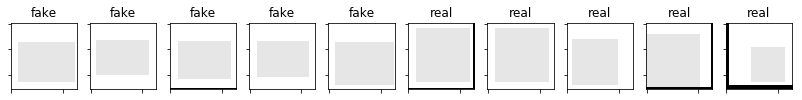

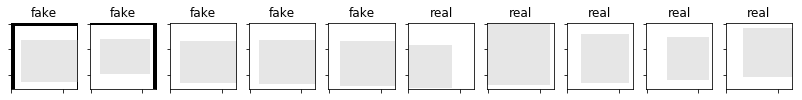

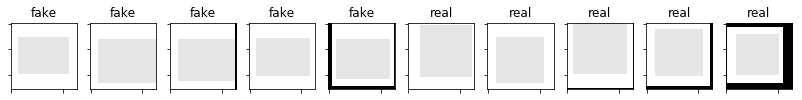

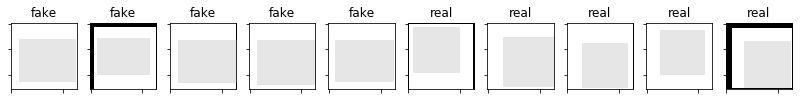

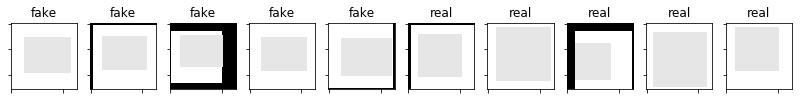

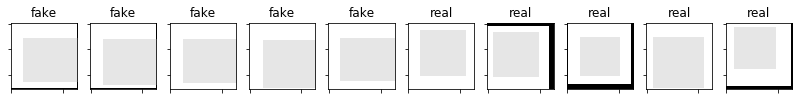

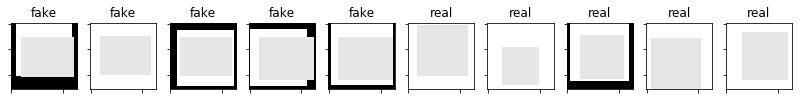

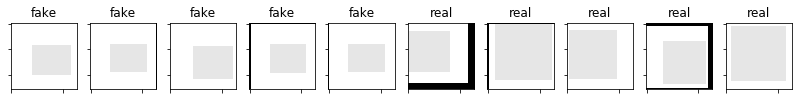

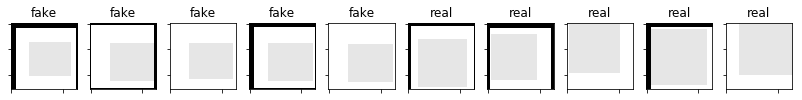

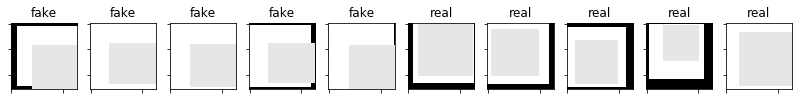

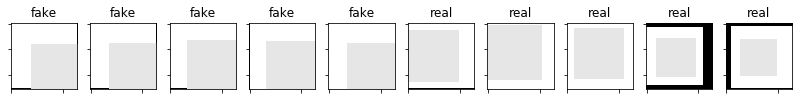

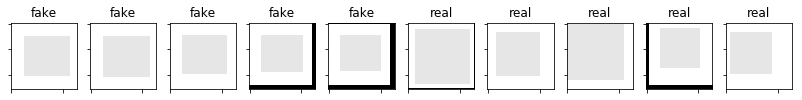

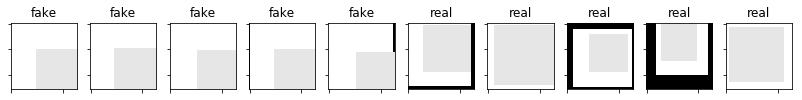

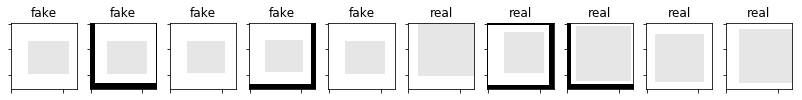

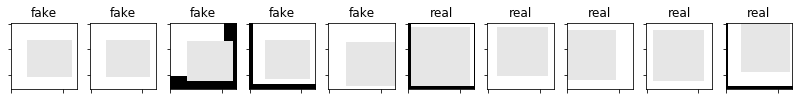

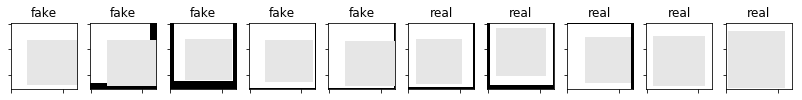

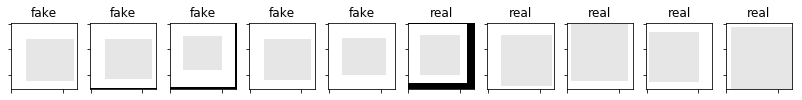

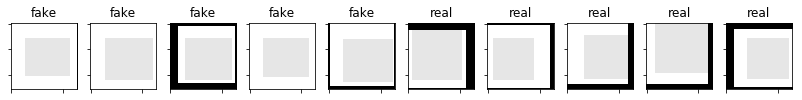

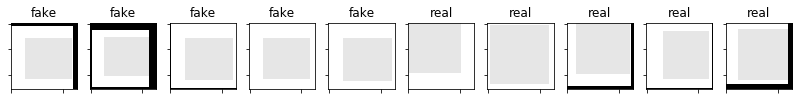

In [ ]:
all_fake_trees = []
all_losses = []
for iter in range(1, n_iters + 1):
    spawn.zero_grad()
    readout.zero_grad()

    readouts = []
    real_trees = []
    for bii in range(bhalf):
        root = TARGET(endh=MAX_HEIGHT, normalize=norml1)
        R_G = Tree.readout_fill(root, readout)
        readouts.append(R_G)
        real_trees.append(root)
    real_readouts = torch.stack(readouts).to(device)

    def nodestruct(child_hv):
        # modularized instructions to create a new node for recursion
        return TARGET(endh=0, h_v=child_hv, normalize=norml1)

    fake_readouts = []
    fake_detached = []
    fake_trees = []
    for bii in range(bhalf):
        root = TARGET(endh=MAX_HEIGHT - 1, normalize=norml1)
        Tree.spawn(root, spawn, spawn.init_noise, nodestruct)
        # Tree.show(root)
        R_G = Tree.readout_fill(root, readout)
        fake_readouts.append(R_G)
        fake_trees.append(root)
        if iter % 10 == 1: # save archive of fake trees
            all_fake_trees.append(root)

        R_G = Tree.readout_fill(root, readout, detach=True)
        fake_detached.append(R_G)
    fake_readouts = torch.stack(fake_readouts).to(device)
    fake_detached = torch.stack(fake_detached).to(device)
    # print(readout.model[0].weight.data.detach().cpu().numpy()[0, :5])

    # GENERATION PHASE

    # -- Generator Training --
    gen_loss = adversarial_loss(discrim(fake_readouts), real_labels)
    gen_loss.backward(retain_graph=True)
    gen_opt.step()

    # -- Discrimination Training --
    # NOTE: Readout gradients carry over to discriminiator training
    discrim.zero_grad()

    real_guesses = discrim(real_readouts)
    real_loss = adversarial_loss(real_guesses, real_labels)
    fake_guesses = discrim(fake_detached)
    fake_loss = adversarial_loss(fake_guesses, fake_labels)

    real_score = score(real_guesses, real_labels)
    fake_score = score(fake_guesses, fake_labels)
    disc_score = (real_score + fake_score) / 2
    assert disc_score <= 1.0

    discrim_loss = (real_loss + fake_loss) / 2

    discrim_loss.backward()
    # if iter % 10 == 0:
    readout_opt.step()
    # else:
    # discrim_opt.step()

    sys.stdout.write('[%d] Generate/L: %.5f  Discrim/L : %.5f  Score: %.2f      \r' % (
        iter,
        gen_loss.item(),
        discrim_loss.item(),
        disc_score))
    sys.stdout.flush()
    all_losses.append((gen_loss.item(), discrim_loss.item(),))

    if iter % 1000 == 0 or iter == 1:
        row_samples('samples/hanoi_fk_%d' % iter, 
                    fake_trees[:5] + real_trees[:5], 
                    denorm=denorml1, 
                    plot=True)

print()

In [9]:
print('hello')dd

hello
